In [1]:
%load_ext autoreload

%autoreload 2
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8


In [2]:
import sys, os, glob
sys.path += ['.']

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from flows.cglow import CGlowFlowSR
from flows.invert import Invert
from flows.cglow.cond_affine_coupling import cond_coupling_nn_glow
from flows.cglow.cond_gaussianize import cond_gaussianize
from flows.glow.affine_coupling import coupling_nn_glow
from flows.cglow.affine_injector import injector_nn_glow
from models.flvm import FlowLVM

import matplotlib.pyplot as plt
import h5py
from matplotlib.colors import LogNorm, SymLogNorm

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

In [5]:
dset_dir = '/home/cluster/hlasco/bulk1/GAN_dataset/'
fList_t  = glob.glob(dset_dir+'/train/*/processed_data/snapshot.h5')
fList_v  = glob.glob(dset_dir+'/validation/*/processed_data/snapshot.h5')
nFiles_t = len(fList_t)

ps_h = 64
ps_l = ps_h//4

# read .h5 file
def readH5(f, n_channels=4):
    f = f.numpy()
    idx = np.random.randint(0,4)
    idy = np.random.randint(0,4)
    idz = np.random.randint(0,4)
    with h5py.File(f, 'r') as fi:
        u_hr = np.array(fi['HR/ux'][idx*ps_h:(idx+1)*ps_h,idy*ps_h:(idy+1)*ps_h,idz*ps_h:(idz+1)*ps_h], dtype=np.float32).reshape(ps_h,ps_h,ps_h,1)
        u_lr = np.array(fi['LR/ux'][idx*ps_l:(idx+1)*ps_l,idy*ps_l:(idy+1)*ps_l,idz*ps_l:(idz+1)*ps_l], dtype=np.float32).reshape(ps_l,ps_l,ps_l,1)
        v_hr = np.array(fi['HR/uy'][idx*ps_h:(idx+1)*ps_h,idy*ps_h:(idy+1)*ps_h,idz*ps_h:(idz+1)*ps_h], dtype=np.float32).reshape(ps_h,ps_h,ps_h,1)
        v_lr = np.array(fi['LR/uy'][idx*ps_l:(idx+1)*ps_l,idy*ps_l:(idy+1)*ps_l,idz*ps_l:(idz+1)*ps_l], dtype=np.float32).reshape(ps_l,ps_l,ps_l,1)
        w_hr = np.array(fi['HR/uz'][idx*ps_h:(idx+1)*ps_h,idy*ps_h:(idy+1)*ps_h,idz*ps_h:(idz+1)*ps_h], dtype=np.float32).reshape(ps_h,ps_h,ps_h,1)
        w_lr = np.array(fi['LR/uz'][idx*ps_l:(idx+1)*ps_l,idy*ps_l:(idy+1)*ps_l,idz*ps_l:(idz+1)*ps_l], dtype=np.float32).reshape(ps_l,ps_l,ps_l,1)
        r_hr = np.array(fi['HR/rho'][idx*ps_h:(idx+1)*ps_h,idy*ps_h:(idy+1)*ps_h,idz*ps_h:(idz+1)*ps_h], dtype=np.float32).reshape(ps_h,ps_h,ps_h,1)
        r_lr = np.array(fi['LR/rho'][idx*ps_l:(idx+1)*ps_l,idy*ps_l:(idy+1)*ps_l,idz*ps_l:(idz+1)*ps_l], dtype=np.float32).reshape(ps_l,ps_l,ps_l,1)

        m_vel = np.mean([u_lr, v_lr, w_lr])
        s_vel = np.std([u_lr, v_lr, w_lr])

        r_hr = np.log10(r_hr)
        r_lr = np.log10(r_lr)

        m_r = np.mean(r_lr)
        s_r = np.std(r_lr)

        u_hr = (u_hr - np.mean(u_lr))/np.std(u_lr)
        u_lr = (u_lr - np.mean(u_lr))/np.std(u_lr)

        v_hr = (v_hr - np.mean(v_lr))/np.std(v_lr)
        v_lr = (v_lr - np.mean(v_lr))/np.std(v_lr)

        w_hr = (w_hr - np.mean(w_lr))/np.std(w_lr)
        w_lr = (w_lr - np.mean(w_lr))/np.std(w_lr)

        r_hr = (r_hr - m_r)/s_r
        r_lr = (r_lr - m_r)/s_r

        ret_lr = np.concatenate((u_lr, v_lr, w_lr, r_lr), axis=-1)
        if n_channels==4:
            ret_hr = np.concatenate((u_hr, v_hr, w_hr, r_hr), axis=-1)
        elif n_channels==3:
            ret_hr = np.concatenate((u_hr, v_hr, w_hr), axis=-1)
        elif n_channels==1:
            ret_hr = r_hr
        return ret_lr, ret_hr 



def readH5_wrapper(filename, n_channels=4):
    # Assuming your data and labels are float32
    # Your input is parse_function, who arg is filename, and you get X and y as output
    # whose datatypes are indicated by the tuple argument
    lr, hr = tf.py_function(readH5, [filename, n_channels], (tf.float32, tf.float32))
    return hr, lr

batch_size = 1
n_channels = 1
# Create dataset of filenames.
X_train_ds = tf.data.Dataset.from_tensor_slices(fList_t)
X_train_ds = X_train_ds.map(lambda x: readH5_wrapper(x, n_channels=n_channels))
X_train_ds = X_train_ds.batch(batch_size).repeat()

In [6]:
iterator = iter(X_train_ds)


In [7]:
hr, lr = iterator.get_next()

In [8]:
print(lr.shape, hr.shape)

(1, 16, 16, 16, 4) (1, 64, 64, 64, 1)


In [9]:
def p_spectrum3d(rho):
    nx, ny, nz = rho.shape
    #rho = 10**(rho)
    Kk = np.zeros((nx,ny,nz))#( (nx//2+1, ny//2+1, nz//2+1))
    Pk = fft_comp(rho)

    kx = np.fft.fftfreq(nx)*nx
    ky = np.fft.fftfreq(ny)*ny
    kz = np.fft.fftfreq(nz)*nz

    # physical limits to the wavenumbers
    kmin = 1.0
    kmax = nx//2+1

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    P_k = np.zeros(len(ncount)-1)

    for n in range(1,len(ncount)):
        P_k[n-1] = np.sum(Pk.flat[whichbin==n])

    k = 0.5*(kbins[0:N-1] + kbins[1:N])
    P_k = P_k[1:N]

    return k[:-1], P_k[:-1]#/np.sum(P_k)

def e_spectrum3d(vel):
    u = vel[:,:,:,0]
    v = vel[:,:,:,1]
    w = vel[:,:,:,2]
    nx, ny, nz = u.shape

    Kk = np.zeros((nx,ny,nz))#( (nx//2+1, ny//2+1, nz//2+1))
    for comp in [u, v, w]:

        Kk += 0.5*fft_comp(comp)

    kx = np.fft.fftfreq(nx)*nx
    ky = np.fft.fftfreq(ny)*ny
    kz = np.fft.fftfreq(nz)*nz

    # physical limits to the wavenumbers
    kmin = 1.0
    kmax = nx//2+1

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_k = np.zeros(len(ncount)-1)

    for n in range(1,len(ncount)):
        E_k[n-1] = np.sum(Kk.flat[whichbin==n])

    k = 0.5*(kbins[0:N-1] + kbins[1:N])
    E_k = E_k[1:N]
    
    #E_tot = 0.5 * (u**2 + v**2 + w**2)

    return k[:-1], E_k[:-1]#/np.sum(E_k)


def fft_comp(u):
    nx, ny, nz = u.shape
    ret = np.fft.fftn(u)#[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    ret = ret/(nx*ny*nz)

    return np.abs(ret**2)


In [10]:
def readCube(f, s=64):
    print(f)
    with h5py.File(f, 'r') as fi:
        u_hr = np.array(fi['HR/ux'][:s, :s, :s], dtype=np.float32).reshape(1,s,s,s,1)
        u_lr = np.array(fi['LR/ux'][:s//4, :s//4, :s//4], dtype=np.float32).reshape(1,s//4,s//4,s//4,1)
        
        v_hr = np.array(fi['HR/uy'][:s, :s, :s], dtype=np.float32).reshape(1,s,s,s,1)
        v_lr = np.array(fi['LR/uy'][:s//4, :s//4, :s//4], dtype=np.float32).reshape(1,s//4,s//4,s//4,1)
        
        w_hr = np.array(fi['HR/uz'][:s, :s, :s], dtype=np.float32).reshape(1,s,s,s,1)
        w_lr = np.array(fi['LR/uz'][:s//4, :s//4, :s//4], dtype=np.float32).reshape(1,s//4,s//4,s//4,1)
        
        r_hr = np.array(fi['HR/rho'][:s, :s, :s], dtype=np.float32).reshape(1,s,s,s,1)
        r_lr = np.array(fi['LR/rho'][:s//4, :s//4, :s//4], dtype=np.float32).reshape(1,s//4,s//4,s//4,1)
        
        r_hr = np.log10(r_hr)
        r_lr = np.log10(r_lr)

        m_r = np.mean(r_lr)
        s_r = np.std(r_lr)

        u_hr = (u_hr - np.mean(u_lr))/np.std(u_lr)
        u_lr = (u_lr - np.mean(u_lr))/np.std(u_lr)

        v_hr = (v_hr - np.mean(v_lr))/np.std(v_lr)
        v_lr = (v_lr - np.mean(v_lr))/np.std(v_lr)

        w_hr = (w_hr - np.mean(w_lr))/np.std(w_lr)
        w_lr = (w_lr - np.mean(w_lr))/np.std(w_lr)

        r_hr = (r_hr - m_r)/s_r
        r_lr = (r_lr - m_r)/s_r
        return np.concatenate((u_lr, v_lr, w_lr, r_lr), axis=-1), np.concatenate((u_hr, v_hr, w_hr, r_hr), axis=-1)        
        

In [56]:
n_channels=1
kwargs_nn={'dim':3, 'min_filters':8, 'max_filters':128, 'num_blocks':0}

affine_coupling = coupling_nn_glow(**kwargs_nn)
cond_coupling = cond_coupling_nn_glow(**kwargs_nn)
injector = injector_nn_glow(**kwargs_nn)
parametrizer = cond_gaussianize(**kwargs_nn)
inpt_channels = n_channels
cond_channels = 4
glow = Invert(CGlowFlowSR(
                   dim=3,
                   upfactor=2,
                   num_layers=3,
                   depth=16,
                   cond_channels=cond_channels,
                   cond_filters=32,
                   cond_resblocks=12,
                   cond_blocks=4,
                   cond_coupling_nn_ctor=cond_coupling,
                   injector_nn_ctor=injector,
                   parameterize_ctor=parametrizer))

learning_rate = 2.0e-4
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
opt_flow = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt_cond = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_8_128_rho = FlowLVM(glow, prior,
                dim=3,
                num_bins=16,
                input_channels=inpt_channels,
                optimizer_flow=opt_flow,
                optimizer_cond=opt_cond)


In [57]:
n_channels=1
kwargs_nn={'dim':3, 'min_filters':32, 'max_filters':32, 'num_blocks':0}

affine_coupling = coupling_nn_glow(**kwargs_nn)
cond_coupling = cond_coupling_nn_glow(**kwargs_nn)
injector = injector_nn_glow(**kwargs_nn)
parametrizer = cond_gaussianize(**kwargs_nn)
inpt_channels = n_channels
cond_channels = 4
glow = Invert(CGlowFlowSR(
                   dim=3,
                   upfactor=2,
                   num_layers=3,
                   depth=16,
                   cond_channels=cond_channels,
                   cond_filters=32,
                   cond_resblocks=12,
                   cond_blocks=4,
                   cond_coupling_nn_ctor=cond_coupling,
                   injector_nn_ctor=injector,
                   parameterize_ctor=parametrizer))

learning_rate = 2.0e-4
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
opt_flow = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt_cond = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_32_32_rho = FlowLVM(glow, prior,
                dim=3,
                num_bins=16,
                input_channels=inpt_channels,
                optimizer_flow=opt_flow,
                optimizer_cond=opt_cond)


In [58]:
n_channels=3
kwargs_nn={'dim':3, 'min_filters':32, 'max_filters':32, 'num_blocks':0}

affine_coupling = coupling_nn_glow(**kwargs_nn)
cond_coupling = cond_coupling_nn_glow(**kwargs_nn)
injector = injector_nn_glow(**kwargs_nn)
parametrizer = cond_gaussianize(**kwargs_nn)
inpt_channels = n_channels
cond_channels = 4
glow = Invert(CGlowFlowSR(
                   dim=3,
                   upfactor=2,
                   num_layers=3,
                   depth=16,
                   cond_channels=cond_channels,
                   cond_filters=32,
                   cond_resblocks=12,
                   cond_blocks=4,
                   cond_coupling_nn_ctor=cond_coupling,
                   injector_nn_ctor=injector,
                   parameterize_ctor=parametrizer))

learning_rate = 2.0e-4
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
opt_flow = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt_cond = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_32_32_vel = FlowLVM(glow, prior,
                dim=3,
                num_bins=16,
                input_channels=inpt_channels,
                optimizer_flow=opt_flow,
                optimizer_cond=opt_cond)
#print(model.param_count())


In [59]:
n_channels=3
kwargs_nn={'dim':3, 'min_filters':8, 'max_filters':128, 'num_blocks':0}

affine_coupling = coupling_nn_glow(**kwargs_nn)
cond_coupling = cond_coupling_nn_glow(**kwargs_nn)
injector = injector_nn_glow(**kwargs_nn)
parametrizer = cond_gaussianize(**kwargs_nn)
inpt_channels = n_channels
cond_channels = 4
glow = Invert(CGlowFlowSR(
                   dim=3,
                   upfactor=2,
                   num_layers=3,
                   depth=16,
                   cond_channels=cond_channels,
                   cond_filters=32,
                   cond_resblocks=12,
                   cond_blocks=4,
                   cond_coupling_nn_ctor=cond_coupling,
                   injector_nn_ctor=injector,
                   parameterize_ctor=parametrizer))

learning_rate = 2.0e-4
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
opt_flow = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt_cond = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_8_128_vel = FlowLVM(glow, prior,
                dim=3,
                num_bins=16,
                input_channels=inpt_channels,
                optimizer_flow=opt_flow,
                optimizer_cond=opt_cond)
#print(model.param_count())

In [60]:
model_8_128_rho._init_checkpoint()
path = '/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_8_128_cond_32_12_4_RHO/'
ckpt_path = tf.train.latest_checkpoint(path)
print(ckpt_path)
model_8_128_rho.checkpoint.restore(ckpt_path)

/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_8_128_cond_32_12_4_RHO/model-31


In [61]:
model_32_32_rho._init_checkpoint()
path = '/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_32_32_cond_32_12_4_RHO/'
ckpt_path = tf.train.latest_checkpoint(path)
print(ckpt_path)
model_32_32_rho.checkpoint.restore(ckpt_path)


/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_32_32_cond_32_12_4_RHO/model-41


In [62]:
model_32_32_vel._init_checkpoint()
path = '/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_32_32_cond_32_12_4_VEL/'
ckpt_path = tf.train.latest_checkpoint(path)
print(ckpt_path)
model_32_32_vel.checkpoint.restore(ckpt_path)


/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_32_32_cond_32_12_4_VEL/model-41


In [63]:
model_8_128_vel._init_checkpoint()
path = '/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_8_128_cond_32_12_4_VEL/'
ckpt_path = tf.train.latest_checkpoint(path)
print(ckpt_path)
model_8_128_vel.checkpoint.restore(ckpt_path)

/home/cluster/hlasco/scratch/srflow_3d/flow_3_16_8_128_cond_32_12_4_VEL/model-29


In [64]:
#from mpl_toolkits.mplot3d import Axes3D
#x = np.linspace(0.,1.0, 500)
#y = np.linspace(0.,1.0, 500)
#xx, yy = np.meshgrid(x,y)
##plt.plot(x, np.log(-x + 1e-7))
##plt.plot(x,np.log(1-x + 1e-7)+np.log(x + 1e-7))
#z = -.5*(yy*np.log(xx + 1e-2) + (1-yy)*np.log(1-x + 1e-2))
#ax = plt.subplot(1,1,1,projection='3d')
#ax.plot_surface(xx, yy, z)
#plt.show()
#
#ax = plt.subplot(1,1,1,projection='3d')
#z = np.log(yy+1e-2) + np.log(1-xx + 1e-2)
#ax.plot_surface(xx, yy, .1*.5*z, rcount=100, ccount=100)

In [65]:
#model.test(shape=[1,32,32,32,1], y_shape=[1,8,8,8,4])

In [66]:
#model.train(X_train_ds, steps_per_epoch=10, num_epochs=10, conditional=True, init=True)

In [67]:
def plotz(model, s, n, tau, c=0):
    #iterator = iter(X_train_ds)
    lr, hr = readCube(fList_t[0], s=s)
    N = 16
    hr = np.float32(hr + np.random.uniform(-.5/N, .5/N, hr.shape))
    lr = np.float32(lr + np.random.uniform(-.5/N, .5/N, lr.shape))
    #lr[:,:,:,:,:3]*=0
    shape = (1,s,s,s,1)
    sr = model.sample(n=1, shape=shape, tau=tau, y_cond=lr)
    sr_spectrum = model.sample(n=n, shape=shape, tau=tau, y_cond=lr)
    sr_det = model.sample(n=1, shape=shape, tau=0.0, y_cond=lr)
    #hr[:,:,:,:,3] = hr[:,:,:,:,3] / np.mean(hr[:,:,:,:,3]**2)**.5
    #sr[:,:,:,:,3] = sr[:,:,:,:,3] / np.mean(sr[:,:,:,:,3]**2)**.5
    print('Sampling Done')
    #z = model.encode(hr, y_cond=lr)

    
    plt.figure(figsize=(4*6,4))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)
    #k_hr, E_hr = e_spectrum3d(hr[0,:,:,:,:])
    k_hr, P_hr = p_spectrum3d(hr[0,:,:,:,3])
    #k_sr_d, E_sr_d = e_spectrum3d(sr_det[0,:,:,:,:])
    k_sr_d, P_sr_d = p_spectrum3d(sr_det[0,:,:,:,3])
    #k_sr, E_sr = e_spectrum3d(sr[0,:,:,:,:])
    k_sr, P_sr = p_spectrum3d(sr[0,:,:,:,3])
    fac = 0
    for i in range(n-1):
        #u = sr_spectrum[i,:,:,:,:] 
        rho = sr_spectrum[i,:,:,:,0] 
        #k_sr, E_sr = e_spectrum3d(u)
        k_sr, P_sr = p_spectrum3d(rho)
        #ax1.loglog(k_sr, E_sr, color='g', alpha=2.0/n, linewidth=3)
        ax2.loglog(k_sr, P_sr, color='g', alpha=2.0/n, linewidth=3)
        #ax3.semilogx(k_sr, 100*(E_sr-E_hr)/(E_hr), color='g', alpha=2.0/n, linewidth=3)
        ax4.semilogx(k_sr, 100*(P_sr-P_hr)/(P_hr), color='g', alpha=2.0/n, linewidth=3)

    #ax3.semilogx(k_sr, 100*(E_sr-E_hr)/(E_hr), color='g', label=r'sampled $\tau=1$')
    #ax3.semilogx(k_hr, 100*(E_hr-E_hr)/(E_hr), 'k--', label=r'ground truth')
    #ax3.semilogx(k_sr_d, 100*(E_sr_d-E_hr)/(E_hr), label=r'sampled $\tau=0$')
    #ax3.fill_between(k_hr, np.zeros_like(k_hr) + 10, np.zeros_like(k_hr) - 10, color='k', alpha=.3)
    #ax3.set_ylim(-50,50)
    #ax1.loglog(k_sr, E_sr, color='g', label=r'sampled $\tau=1$')
    #ax1.loglog(k_hr, E_hr, 'k--', label=r'ground truth')
    #ax1.loglog(k_sr_d, E_sr_d, label=r'sampled $\tau=0$')
    
    ax4.semilogx(k_sr, 100*(P_sr-P_hr)/(P_hr), color='g', label=r'sampled')
    ax4.semilogx(k_hr, 100*(P_hr-P_hr)/(P_hr), 'k--', label=r'ground truth')
    ax4.semilogx(k_sr_d, 100*(P_sr_d-P_hr)/(P_hr), label=r'sampled $\tau=0$')
    ax4.fill_between(k_hr, np.zeros_like(k_hr) + 10, np.zeros_like(k_hr) - 10, color='k', alpha=.3)
    ax4.set_ylim(-50,50)
    ax2.loglog(k_sr, P_sr, color='g', label=r'sampled')
    ax2.loglog(k_hr, P_hr, 'k--', label=r'ground truth')
    ax2.loglog(k_sr_d, P_sr_d, label=r'sampled $\tau=0$')

    plt.legend()
    vmax = np.max((hr[0,:,:,0,c]))
    vmin = np.min((hr[0,:,:,0,c]))

    cmap="inferno"

    plt.figure(figsize=(4*6,6))
    ax = plt.subplot(1,4,1)
    plt.imshow(hr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'ground truth')
    plt.subplot(1,4,2)
    plt.imshow(sr[0,:,:,0,0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'sampled $\tau=1$')
    plt.subplot(1,4,3)
    plt.imshow(sr_det[0,:,:,0,0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'sampled $\tau=0$')
    plt.subplot(1,4,4)
    plt.imshow(lr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    #plt.imshow(sr[0,:,:,32,c]-sr_det[0,:,:,32,c], cmap=cmap)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'low res')
    #plt.title(r'$SR_{\tau=1} - SR_{\tau=0}$')
    plt.show()
    
    #vmax = np.max((hr[0,:,:,0,3]))
    #vmin = np.min((hr[0,:,:,0,3]))
    #cmap="inferno"
    #plt.figure(figsize=(4*6,6))
    #ax = plt.subplot(1,4,1)
    #plt.imshow(hr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    #plt.yticks([])
    #plt.xticks([])
    #plt.title(r'ground truth')
    #plt.subplot(1,4,2)
    #plt.imshow(sr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    #plt.yticks([])
    #plt.xticks([])
    #plt.title(r'sampled $\tau=1$')
    #plt.subplot(1,4,3)
    #plt.imshow(sr_det[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    #plt.yticks([])
    #plt.xticks([])
    #plt.title(r'sampled $\tau=0$')
    #plt.subplot(1,4,4)
    #plt.imshow(lr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    ##plt.imshow(sr[0,:,:,32,3]-sr_det[0,:,:,32,3], cmap=cmap)
    #plt.yticks([])
    #plt.xticks([])
    ##plt.title(r'$SR_{\tau=1} - SR_{\tau=0}$')
    #plt.title(r'low res')
    #plt.show()

In [71]:
def eval_model_v(model, s, n, tau, c=0):
    #iterator = iter(X_train_ds)
    lr, hr = readCube(fList_t[0], s=s)
    N = 16
    #hr = np.float32(hr + np.random.uniform(-.5/N, .5/N, hr.shape))
    #lr = np.float32(lr + np.random.uniform(-.5/N, .5/N, lr.shape))
    shape = s
    sr = model.sample(n=1, shape=shape, tau=tau, y_cond=lr)
    sr_spectrum = model.sample(n=n, shape=shape, tau=tau, y_cond=lr)
    sr_det = model.sample(n=1, shape=shape, tau=0.0, y_cond=lr)

    print('Sampling Done')
    plt.figure(figsize=(4*6,4))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)

    k_hr, E_hr = e_spectrum3d(hr[0,:,:,:,:])
    k_sr_d, E_sr_d = e_spectrum3d(sr_det[0,:,:,:,:])
    k_sr, E_sr = e_spectrum3d(sr[0,:,:,:,:])
    k_lr, E_lr = e_spectrum3d(lr[0,:,:,:,:3])
    fac = 0
    for i in range(n-1):
        u = sr_spectrum[i,:,:,:,:] 
        k_sr, E_sr = e_spectrum3d(u)
        ax1.loglog(k_sr, E_sr, color='g', alpha=2.0/n, linewidth=3)
        ax2.semilogx(k_sr, 100*(E_sr-E_hr)/(E_hr), color='g', alpha=2.0/n, linewidth=3)
    
    ax2.semilogx(k_sr, 100*(E_sr-E_hr)/(E_hr), color='g', label=r'sampled')
    ax2.semilogx(k_hr, 100*(E_hr-E_hr)/(E_hr), 'k--', label=r'high_res')
    
    #ax1.semilogx(k_lr, 100*(E_lr-E_hr)/(E_hr), 'k--', label=r'low res')
    ax2.semilogx(k_sr_d, 100*(E_sr_d-E_hr)/(E_hr), label=r'sampled $\tau=0$')
    ax2.fill_between(k_hr, np.zeros_like(k_hr) + 10, np.zeros_like(k_hr) - 10, color='k', alpha=.3)
    ax2.set_ylim(-50,50)
    ax1.loglog(k_sr, E_sr, color='g', label=r'sampled $\tau=1$')
    ax1.loglog(k_hr, E_hr, 'k--', label=r'high res')
    ax1.loglog(k_lr, E_lr, 'r--', label=r'low res')
    ax1.loglog(k_sr_d, E_sr_d, label=r'sampled $\tau=0$')

    plt.legend()
    vmax = np.max((hr[0,:,:,0,c]))
    vmin = np.min((hr[0,:,:,0,c]))

    cmap="RdBu_r"

    plt.figure(figsize=(4*6,6))
    ax = plt.subplot(1,4,1)
    plt.imshow(hr[0,:,:,0,c], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'ground truth')
    plt.subplot(1,4,2)
    plt.imshow(sr[0,:,:,0,c], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'sampled $\tau=1$')
    plt.subplot(1,4,3)
    plt.imshow(sr_det[0,:,:,0,c], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'sampled $\tau=0$')
    plt.subplot(1,4,4)
    plt.imshow(lr[0,:,:,0,c], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'low res')
    plt.show()

In [72]:
def eval_model_rho(model, s, n, tau):
    #iterator = iter(X_train_ds)
    lr, hr = readCube(fList_v[0], s=s)
    N = 12
    #hr = np.float32(hr + np.random.uniform(-.5/N, .5/N, hr.shape))
    lr = np.float32(lr + np.random.uniform(-.5/N, .5/N, lr.shape))
    shape = s
    sr = model.sample(n=1, shape=shape, tau=tau, y_cond=lr)
    sr_spectrum = model.sample(n=n, shape=shape, tau=tau, y_cond=lr)
    sr_det = model.sample(n=1, shape=shape, tau=0.0, y_cond=lr)

    print('Sampling Done')
    plt.figure(figsize=(4*6,4))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)

    k_hr, P_hr = p_spectrum3d(hr[0,:,:,:,3])
    k_lr, P_lr = p_spectrum3d(lr[0,:,:,:,3])
    k_sr_d, P_sr_d = p_spectrum3d(sr_det[0,:,:,:,0])
    k_sr, P_sr = p_spectrum3d(sr[0,:,:,:,0])
    fac = 0
    for i in range(n-1):
        rho = sr_spectrum[i,:,:,:,0] 
        k_sr, P_sr = p_spectrum3d(rho)
        ax1.loglog(k_sr, P_sr, color='g', alpha=2.0/n, linewidth=3)
        ax2.semilogx(k_sr, 100*(P_sr-P_hr)/(P_hr), color='g', alpha=2.0/n, linewidth=3)
    
    ax2.semilogx(k_sr, 100*(P_sr-P_hr)/(P_hr), color='g', label=r'sampled')
    ax2.semilogx(k_hr, 100*(P_hr-P_hr)/(P_hr), 'k--', label=r'high res')
    ax2.semilogx(k_sr_d, 100*(P_sr_d-P_hr)/(P_hr), label=r'sampled $\tau=0$')
    ax2.fill_between(k_hr, np.zeros_like(k_hr) + 10, np.zeros_like(k_hr) - 10, color='k', alpha=.3)
    ax2.set_ylim(-50,50)
    ax1.loglog(k_sr, P_sr, color='g', label=r'sampled')
    ax1.loglog(k_hr, P_hr, 'k--', label=r'high res')
    ax1.loglog(k_lr, P_lr, 'r--', label=r'low res')
    ax1.loglog(k_sr_d, P_sr_d, label=r'sampled $\tau=0$')

    plt.legend()
    vmax = np.max((hr[0,:,:,0,3]))
    vmin = np.min((hr[0,:,:,0,3]))

    cmap="inferno"

    plt.figure(figsize=(4*6,6))
    ax = plt.subplot(1,4,1)
    plt.imshow(hr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'ground truth')
    plt.subplot(1,4,2)
    plt.imshow(sr[0,:,:,0,0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'sampled $\tau=1$')
    plt.subplot(1,4,3)
    plt.imshow(sr_det[0,:,:,0,0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'sampled $\tau=0$')
    plt.subplot(1,4,4)
    plt.imshow(lr[0,:,:,0,3], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'low res')
    plt.show()

In [73]:
s=128
n=5

/home/cluster/hlasco/bulk1/GAN_dataset//validation/4681_5210_4372/processed_data/snapshot.h5
Sampling Done


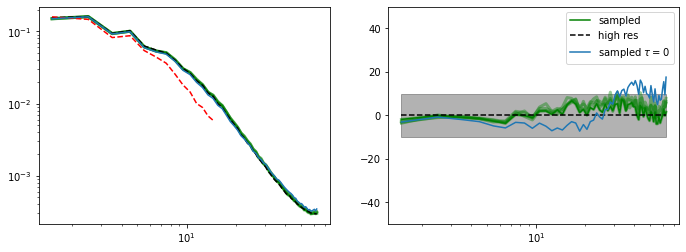

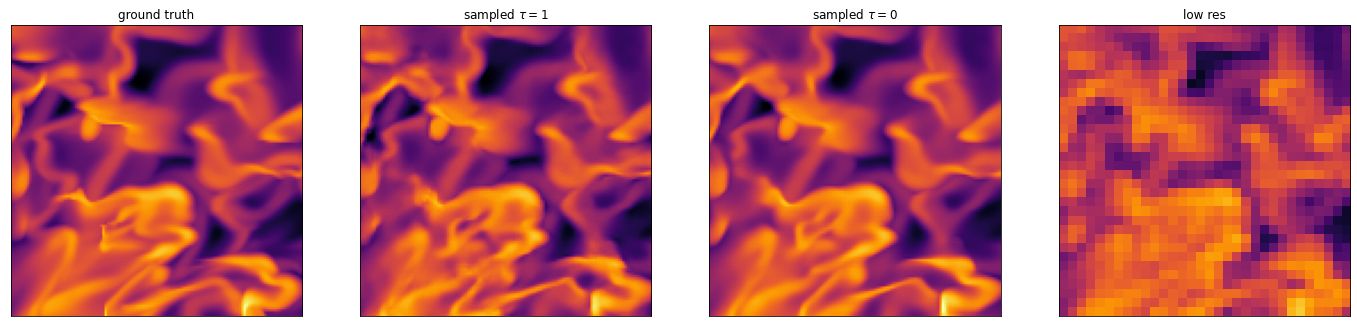

In [74]:
eval_model_rho(model_8_128_rho, s=s,
               n=n, tau=.7)

/home/cluster/hlasco/bulk1/GAN_dataset//train/4760_0142_0231/processed_data/snapshot.h5
Sampling Done


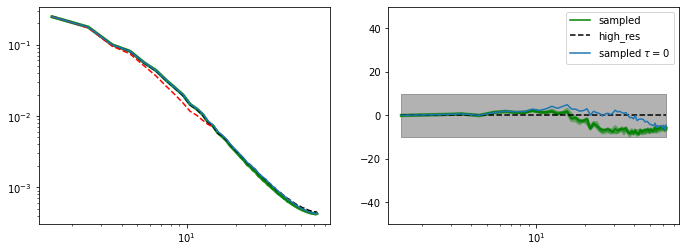

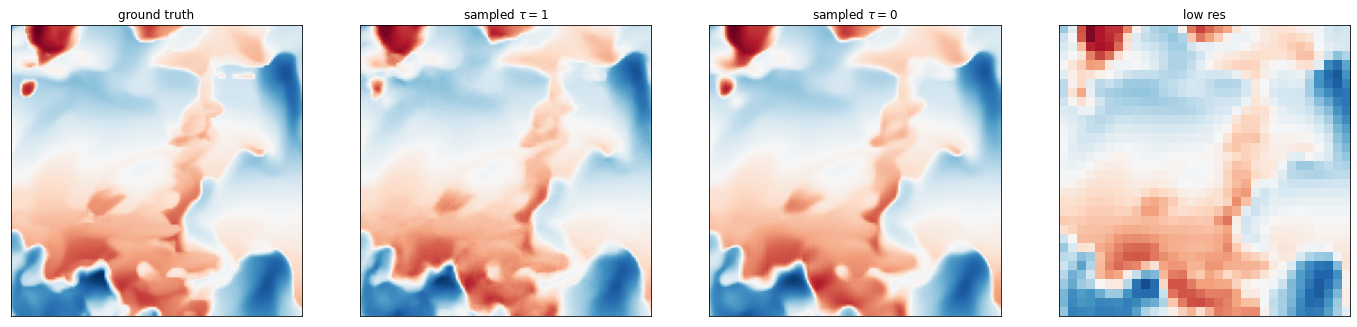

In [75]:
eval_model_v(model_8_128_vel, s=s, n=n, tau=1.0)

/home/cluster/hlasco/bulk1/GAN_dataset//validation/4681_5210_4372/processed_data/snapshot.h5
Sampling Done


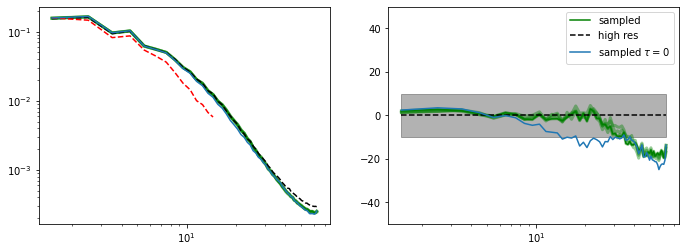

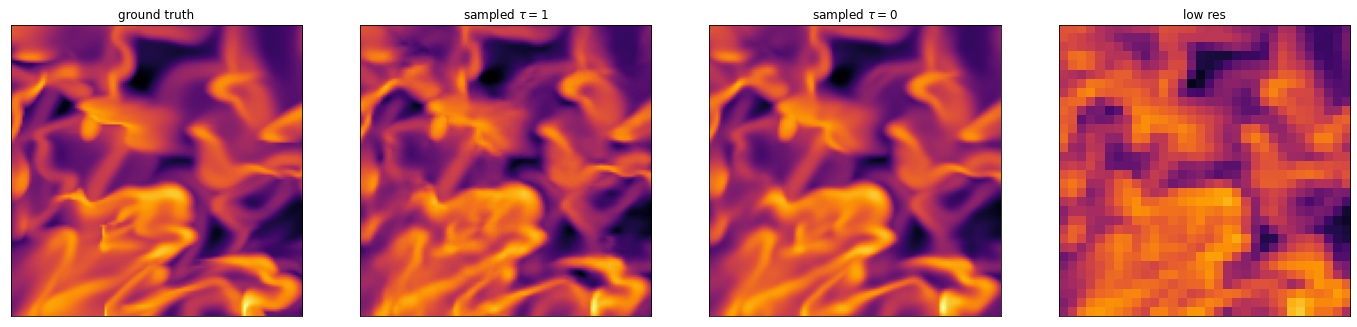

In [76]:
eval_model_rho(model_32_32_rho,s=s,
               n=n, tau=.7)

/home/cluster/hlasco/bulk1/GAN_dataset//train/4760_0142_0231/processed_data/snapshot.h5
Sampling Done


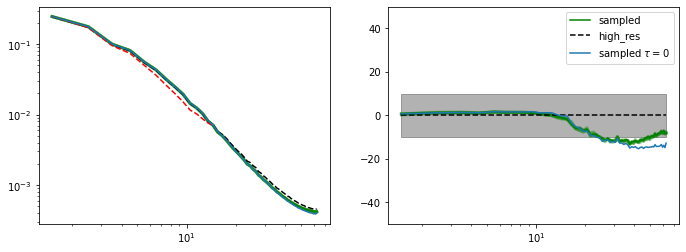

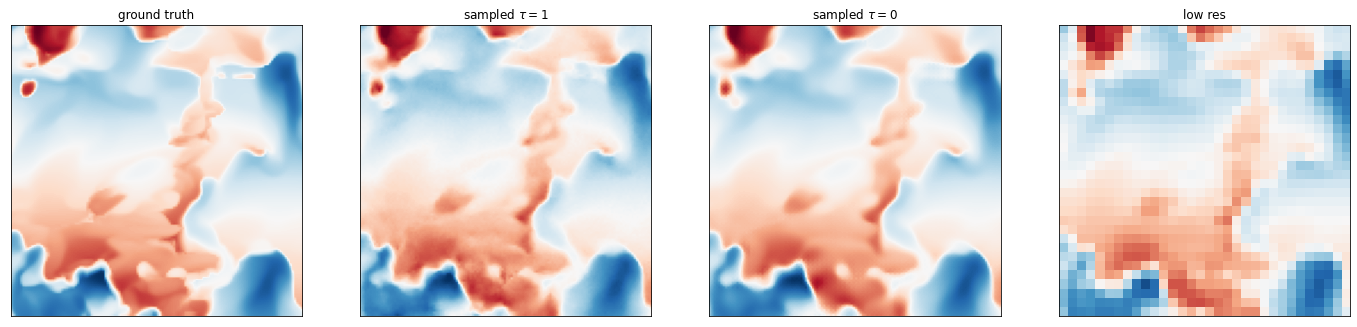

In [77]:
eval_model_v(model_32_32_vel, s=s, 
             n=n, tau=1.0)

In [207]:
def spectralVelInc(u, r):
    NX,NY,NZ = u.shape
    kx = np.fft.fftfreq(NX)
    ky = np.fft.fftfreq(NY)
    kz = np.fft.rfftfreq(NZ)
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)
    u_f = np.fft.rfftn(u)
    
    fac_inc = np.sinc(2*k*r) - 1
    
    du_f = u_f * fac_inc
    du = np.fft.irfftn(du_f)
    
    return du

In [201]:
s=128
tau = 1.
lr, hr = readCube(fList_v[0], s=s)
z_v = model_8_128_vel.prior.sample((1,s,s,s,3)).numpy()
z_r = model_8_128_vel.prior.sample((1,s,s,s,1)).numpy()

sr_v = model_8_128_vel.decode(tau*z_v, y_cond=lr).numpy()
sr_r = model_8_128_rho.decode(tau*z_r, y_cond=lr).numpy()


/home/cluster/hlasco/bulk1/GAN_dataset//validation/4681_5210_4372/processed_data/snapshot.h5


In [202]:
sr = np.concatenate([sr_v, sr_r], axis=-1)

In [244]:
n=1
sr_vincr = spectralVelInc(sr[0, :,:,:, 2],n)
hr_vincr = spectralVelInc(hr[0, :,:,:, 2],n)

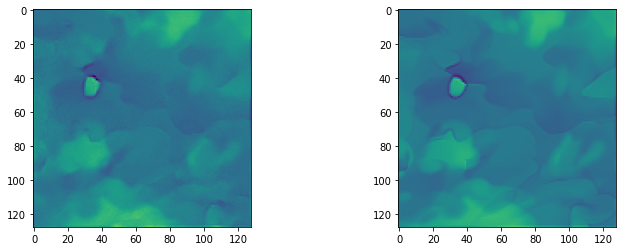

In [245]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
vmin = hr_vincr.min()
vmax = hr_vincr.max()
ax[0].imshow(sr_vincr[:,:,0], vmin=vmin, vmax=vmax)
ax[1].imshow(hr_vincr[:,:,0], vmin=vmin, vmax=vmax)

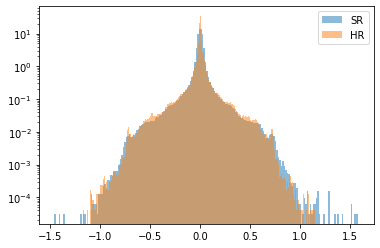

In [246]:
h = plt.hist(sr_vincr.flatten(), bins=200, log=True, density=True, alpha=.5, label='SR')
h = plt.hist(hr_vincr.flatten(), bins=200, log=True, density=True, alpha=.5, label='HR')
plt.legend()

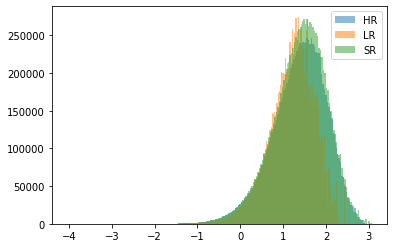

In [278]:
h = plt.hist(hr[:,:,:,:,3].flatten(), bins=200, log=False, weights=10**hr[:,:,:,:,3].flatten(), alpha=.5, label='HR')
h = plt.hist(lr[:,:,:,:,3].flatten(), bins=200, log=False, weights=10**lr[:,:,:,:,3].flatten()*64, alpha=.5, label='LR')
h = plt.hist(sr[:,:,:,:,3].flatten(), bins=200, log=False, weights=10**sr[:,:,:,:,3].flatten(), alpha=.5, label='SR')

plt.legend()

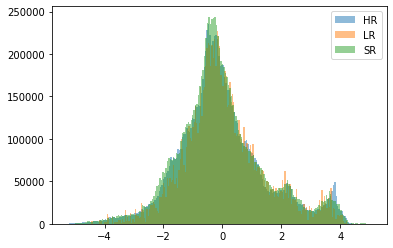

In [279]:
h = plt.hist(hr[:,:,:,:,0].flatten(), bins=200, log=False, weights=10**hr[:,:,:,:,3].flatten(), alpha=.5, label='HR')
h = plt.hist(lr[:,:,:,:,0].flatten(), bins=200, log=False, weights=10**lr[:,:,:,:,3].flatten()*64, alpha=.5, label='LR')
h = plt.hist(sr[:,:,:,:,0].flatten(), bins=200, log=False, weights=10**sr[:,:,:,:,3].flatten(), alpha=.5, label='SR')

plt.legend()

In [273]:
np.sum(10**sr[:,:,:,:,3].flatten())

11355625.0

In [276]:
np.sum(10**lr[:,:,:,:,3].flatten())*64

11246466.0

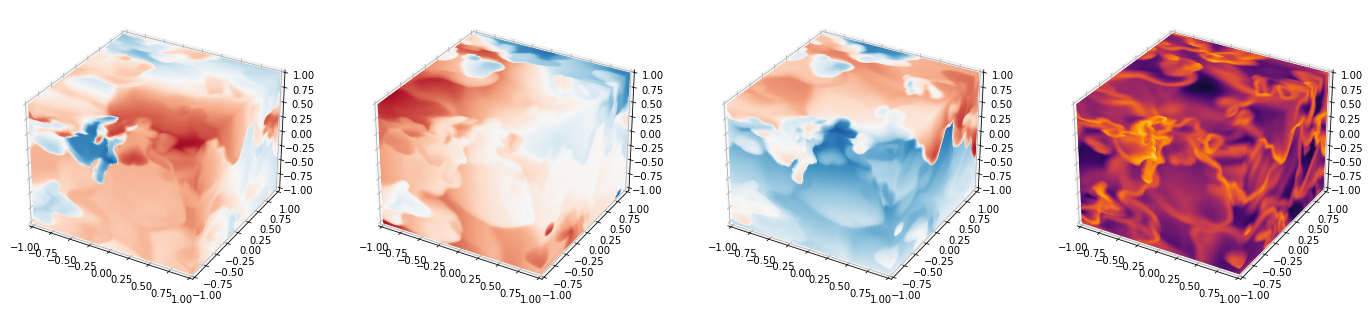

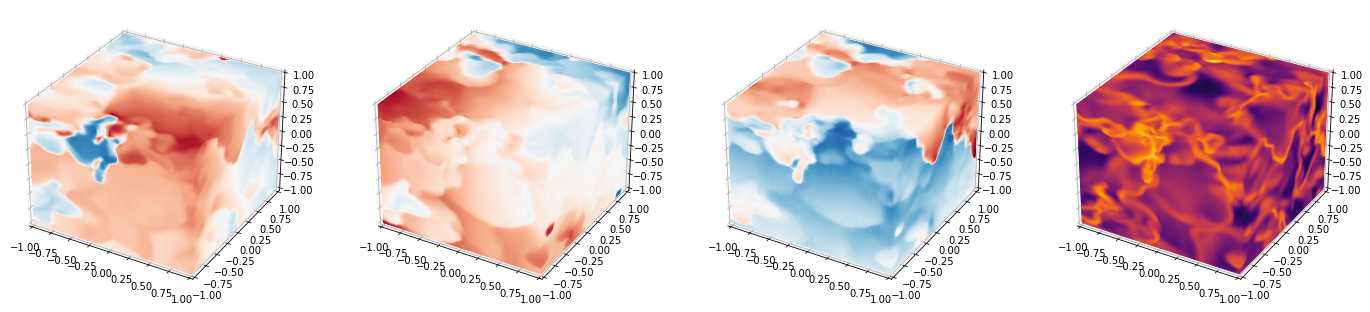

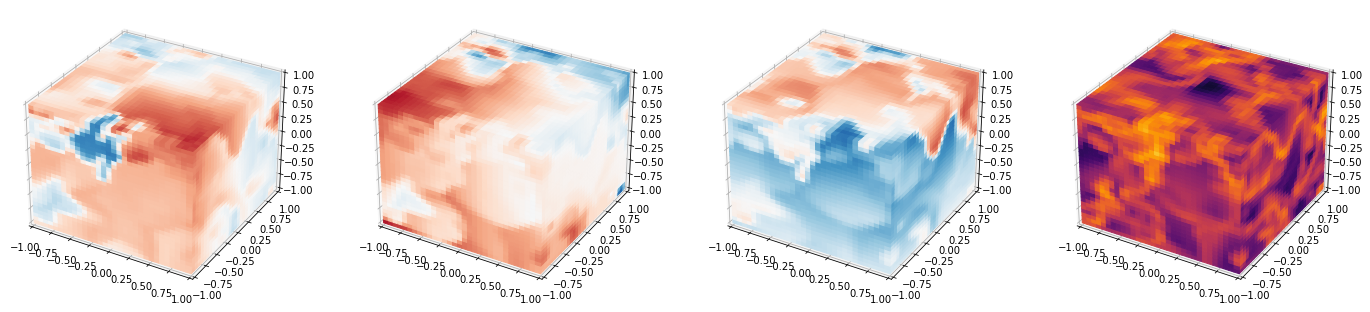

In [206]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

X = Y = Z = np.linspace(-1, 1, s)
X, Y = np.meshgrid(X, X)
levels = 100
fig = plt.figure(figsize=(24,18))
m = np.zeros(4)
M = np.zeros(4)
for cnum in range(4):
    ax = plt.subplot(1,4,cnum+1,projection='3d')
    if cnum==3:
        cmap='inferno'
        cm=plt.cm.inferno
    else:
        cmap='RdBu'
        cm=plt.cm.RdBu
    u1 = hr[0,:,:,-1,cnum]
    u2 = hr[0,:,-1,:,cnum]
    u3 = hr[0,0,:,:,cnum].T
    m[cnum] = 1.2*np.min([u1, u2, u3])
    M[cnum] = 1.2*np.max([u1, u2, u3])
    norm=mpl.colors.Normalize(vmin=m[cnum], vmax=M[cnum])
    ax.plot_surface(1, X, Y, facecolors=cm(norm(u2.T)),rstride=1, cstride=1,shade=False)
    ax.plot_surface(X, -1, Y, facecolors=cm(norm(u3)),rstride=1, cstride=1, shade=False)
    ax.plot_surface(X, Y, np.atleast_2d(1), facecolors=cm(norm(u1)),rstride=1, shade=False,cstride=1)
    # setting 3D-axis-limits:    
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)

plt.show()
fig = plt.figure(figsize=(24,18))

for cnum in range(4):
    ax = plt.subplot(1,4,cnum+1,projection='3d')
    if cnum==3:
        cmap='inferno'
        cm=plt.cm.inferno
    else:
        cmap='RdBu'
        cm=plt.cm.RdBu
    u1 = sr[0,:,:,-1,cnum]
    u2 = sr[0,:,-1,:,cnum]
    u3 = sr[0,0,:,:,cnum].T
    
    norm=mpl.colors.Normalize(vmin=m[cnum], vmax=M[cnum])
    # this is the example that worked for you:
    ax.plot_surface(1, X, Y, facecolors=cm(norm(u2.T)), norm=norm, rstride=1, cstride=1, shade=False)
    ax.plot_surface(X, -1, Y, facecolors=cm(norm(u3)), norm=norm, rstride=1, cstride=1, shade=False)
    ax.plot_surface(X, Y, np.atleast_2d(1), facecolors=cm(norm(u1)), norm=norm, rstride=1, shade=False,cstride=1)
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)
plt.show()

X = np.linspace(-1, 1, s//4)
X, Y = np.meshgrid(X, X)
fig = plt.figure(figsize=(24,18))
for cnum in range(4):
    ax = plt.subplot(1,4,cnum+1,projection='3d')
    if cnum==3:
        cmap='inferno'
        cm=plt.cm.inferno
    else:
        cmap='RdBu'
        cm=plt.cm.RdBu
    u1 = lr[0,:,:,-1,cnum]
    u2 = lr[0,:,-1,:,cnum]
    u3 = lr[0,0,:,:,cnum].T
    
    norm=mpl.colors.Normalize(vmin=m[cnum], vmax=M[cnum])
    ax.plot_surface(1, X, Y, facecolors=cm(norm(u2.T)), rstride=1, cstride=1, shade=False)
    ax.plot_surface(X, -1, Y, facecolors=cm(norm(u3)), rstride=1, cstride=1, shade=False)
    ax.plot_surface(X, Y, np.atleast_2d(1), facecolors=cm(norm(u1)), rstride=1, shade=False,cstride=1)
    # setting 3D-axis-limits:    
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)
plt.show()